In [ ]:
import os, sys

source = os.path.join(os.getcwd(), 'libs')
if source not in sys.path:
    sys.path.append(source)

# Utils

In [ ]:
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

train_set = torch.utils.data.ConcatDataset((
    CIFAR10('CIFAR10', train=True, download=True, transform=T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomCrop(32, padding=4),
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])),
    CIFAR10('CIFAR10', train=True, transform=T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomCrop(32, padding=4),
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]))
))
test_set = CIFAR10('CIFAR10', train=False, download=True, transform=T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, pin_memory=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


In [ ]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    _, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
from tqdm.notebook import tqdm

def process(network, optimizer, scheduler, criterion, num_epochs, device='cpu', title=''):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        network.train()
        running_loss, running_accuracy = 0.0, 0.0
        for images, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            logits = network(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item() * images.shape[0]
            running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
            
        train_losses += [running_loss / len(train_loader.dataset)]
        train_accuracies += [running_accuracy / len(train_loader.dataset)]
        
        network.eval()
        running_loss, running_accuracy = 0.0, 0.0
        for images, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            
            with torch.no_grad():
                logits = network(images)
                loss = criterion(logits, labels)
            
            running_loss += loss.item() * images.shape[0]
            running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
            
        test_losses += [running_loss / len(test_loader.dataset)]
        test_accuracies += [running_accuracy / len(test_loader.dataset)]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
        print(f'Current best test accuracy: {max(test_accuracies)}')

        torch.save(network.state_dict(), os.path.join(os.getcwd(), f'drive/MyDrive/my_libs/network_{title}.pt'))
        torch.save(optimizer.state_dict(), os.path.join(os.getcwd(), f'drive/MyDrive/my_libs/optim_{title}.pt'))
        torch.save(scheduler.state_dict(), os.path.join(os.getcwd(), f'drive/MyDrive/my_libs/sched_{title}.pt'))

# Resnet20 with max ranks clipped to [0, 10]

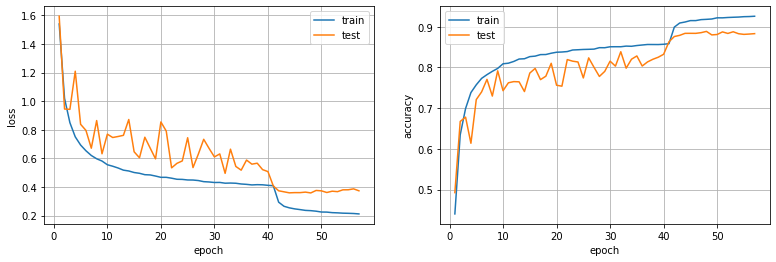

Current best test accuracy: 0.8886


Training 58/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(1234)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
network = Img_CIFARResNet20_TT(ranks=10).to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device, title='rank10')

In [ ]:
from resnet import Img_CIFARResNet20_TT, Img_CIFARResNet20

network_tt = Img_CIFARResNet20_TT(ranks=10)
n_tt = sum(p.numel() for p in network_tt.parameters())
network = Img_CIFARResNet20()
n = sum(p.numel() for p in network.parameters())

print('Common:', n)
print('TT:', n_tt)
print('Ratio:', round(n / n_tt, 2))

Common: 269722
TT: 48558
Ratio: 5.55


# Resnet20 with max ranks clipped to [0, 20]

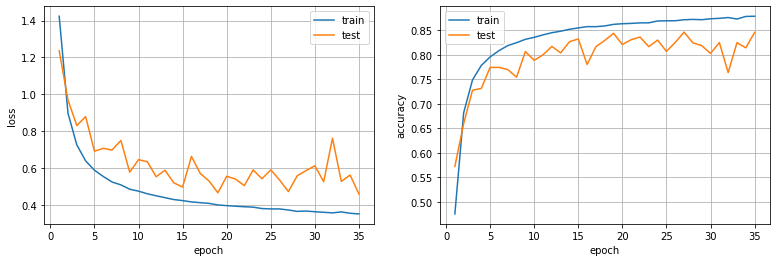

Current best test accuracy: 0.846


Training 36/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
network = Img_CIFARResNet20_TT(ranks=20).to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device)

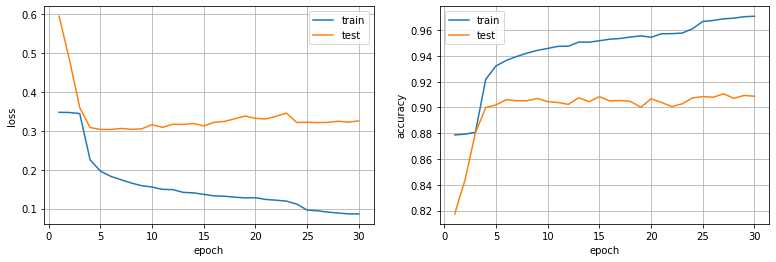

Current best test accuracy: 0.9106


Training 31/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

network = Img_CIFARResNet20_TT(ranks=20)
network.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/network_.pt'), map_location=torch.device('cpu')))
network = network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
optimizer.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/optim_.pt'), map_location=torch.device('cpu')))

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
scheduler.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/sched_.pt'), map_location=torch.device('cpu')))

criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device)

In [ ]:
from resnet import Img_CIFARResNet20_TT, Img_CIFARResNet20

network_tt = Img_CIFARResNet20_TT(ranks=20)
n_tt = sum(p.numel() for p in network_tt.parameters())
network = Img_CIFARResNet20()
n = sum(p.numel() for p in network.parameters())

print('Common:', n)
print('TT:', n_tt)
print('Ratio:', round(n / n_tt, 2))

Common: 269722
TT: 179458
Ratio: 1.5


# Resnet20 with max ranks clipped to [0, 10] and kernel size 5

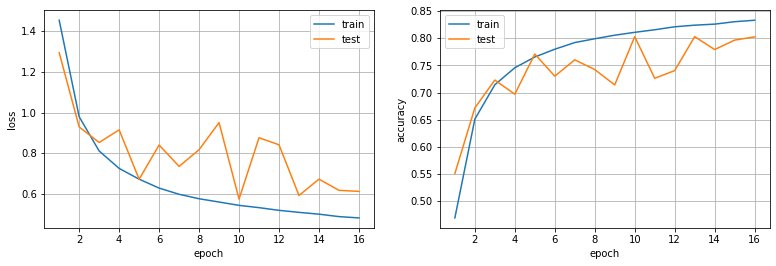

Current best test accuracy: 0.8028


Training 17/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
network = Img_CIFARResNet20_TT(kernel_size=5, ranks=10).to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device, title='rank10_ks5')

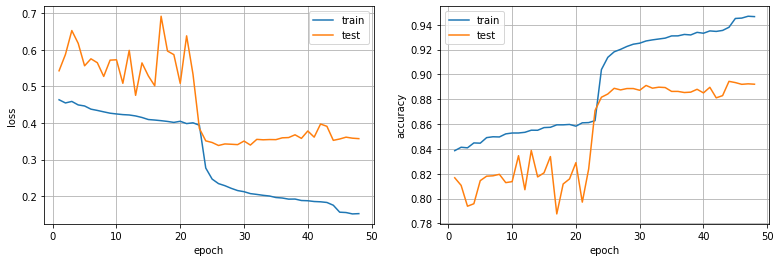

Current best test accuracy: 0.8944


Training 49/82:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

network = Img_CIFARResNet20_TT(kernel_size=5, ranks=10)
network.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/network_rank10_ks5.pt'), map_location=torch.device('cpu')))
network = network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
optimizer.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/optim_rank10_ks5.pt'), map_location=torch.device('cpu')))

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
scheduler.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/sched_rank10_ks5.pt'), map_location=torch.device('cpu')))

criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device)

In [ ]:
from resnet import Img_CIFARResNet20_TT, Img_CIFARResNet20

network_tt = Img_CIFARResNet20_TT(kernel_size=5, ranks=10)
n_tt = sum(p.numel() for p in network_tt.parameters())
network = Img_CIFARResNet20()
n = sum(p.numel() for p in network.parameters())

print('Common:', n)
print('TT:', n_tt)
print('Ratio:', round(n / n_tt, 2))

Common: 269722
TT: 52206
Ratio: 5.17


# Resnet20 with max ranks clipped to [0, 20] and kernel size 19

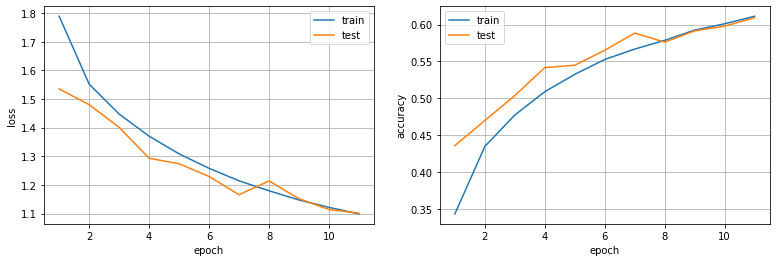

Current best test accuracy: 0.6093


Training 12/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
network = Img_CIFARResNet20_TT(kernel_size=19, ranks=20).to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device, title='rank20_ks19')

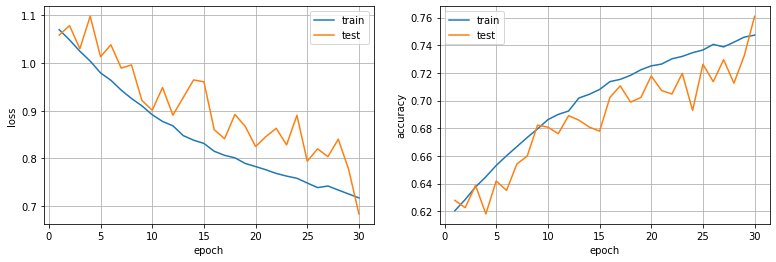

Current best test accuracy: 0.761


Training 31/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

network = Img_CIFARResNet20_TT(kernel_size=19, ranks=20)
network.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/network_rank20_ks19.pt'), map_location=torch.device('cpu')))
network = network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
optimizer.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/optim_rank20_ks19.pt'), map_location=torch.device('cpu')))

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
scheduler.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/sched_rank20_ks19.pt'), map_location=torch.device('cpu')))

criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device, title='rank20_ks19')

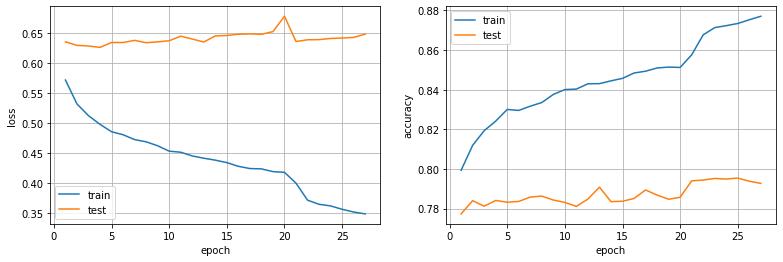

Current best test accuracy: 0.7954


Training 28/82:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

network = Img_CIFARResNet20_TT(kernel_size=19, ranks=20)
network.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/network_rank20_ks19.pt'), map_location=torch.device('cpu')))
network = network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
optimizer.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/optim_rank20_ks19.pt'), map_location=torch.device('cpu')))

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
scheduler.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/sched_rank20_ks19.pt'), map_location=torch.device('cpu')))

criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device, title='rank20_ks19')

# Resnet20 with max ranks clipped to [0, 20] and kernel size 5

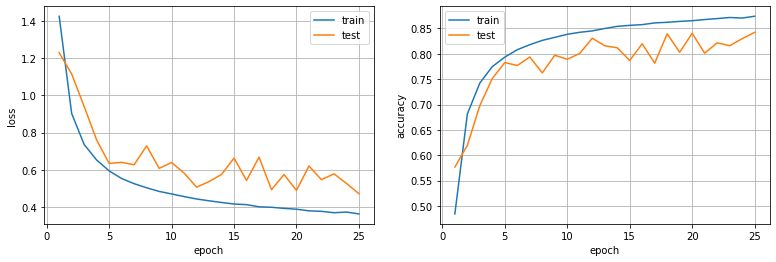

Current best test accuracy: 0.8423


Training 26/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
network = Img_CIFARResNet20_TT(kernel_size=5, ranks=20).to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device, title='rank20_ks5')

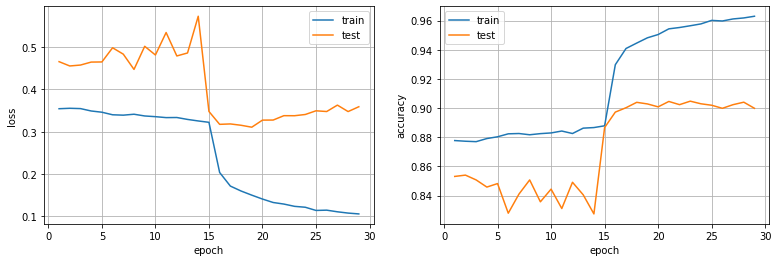

Current best test accuracy: 0.9047


Training 30/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

network = Img_CIFARResNet20_TT(kernel_size=5, ranks=20)
network.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/network_rank20_ks5.pt'), map_location=torch.device('cpu')))
network = network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
optimizer.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/optim_rank20_ks5.pt'), map_location=torch.device('cpu')))

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
scheduler.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/sched_rank20_ks5.pt'), map_location=torch.device('cpu')))

criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device, title='rank20_ks5')

# Resnet20 with max ranks clipped to [0, 20], kernel size 5 and gaussian mask

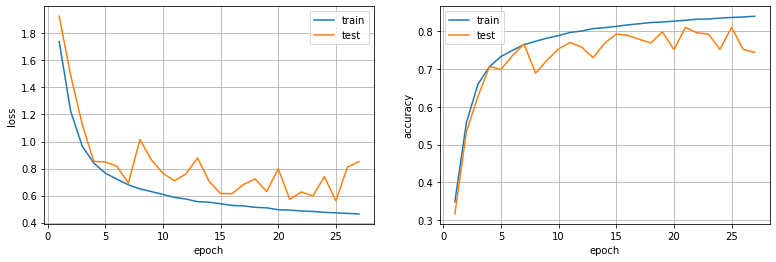

Current best test accuracy: 0.8108


Training 28/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
network = Img_CIFARResNet20_TT(kernel_size=5, ranks=20, gaussian=True).to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device, title='rank20_ks5_g')

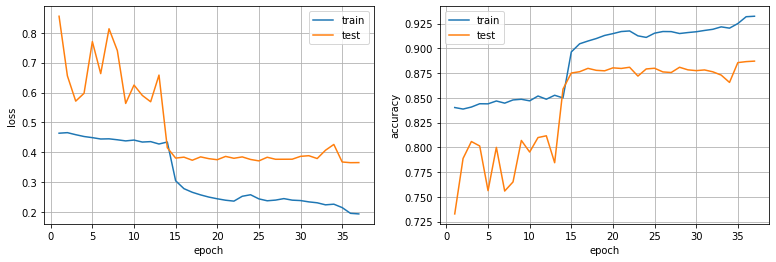

Current best test accuracy: 0.8871


Training 38/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

network = Img_CIFARResNet20_TT(kernel_size=5, ranks=20, gaussian=True)
network.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/network_rank20_ks5_g.pt'), map_location=torch.device('cpu')))
network = network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
optimizer.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/optim_rank20_ks5_g.pt'), map_location=torch.device('cpu')))

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
scheduler.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/sched_rank20_ks5_g.pt'), map_location=torch.device('cpu')))

criterion = torch.nn.CrossEntropyLoss() 
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device, title='rank20_ks5_g')

In [ ]:
from resnet import Img_CIFARResNet20_TT

torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

trained_network = Img_CIFARResNet20_TT(kernel_size=5, ranks=20, gaussian=True)
trained_network.load_state_dict(
    torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/network_rank20_ks5_g.pt'),
               map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
for l in ['layer1.', 'layer2.', 'layer3.']:
    for i in ['0.', '1.', '2.']:
        for c in ['conv1.', 'conv2.']:
            sigma = trained_network.get_parameter(l + i + c + 'sigma')
            print(l + i + c + 'sigma:', sigma)

            grid = torch.arange(-2, 3) ** 2
            power = -(grid.unsqueeze(0) + grid.unsqueeze(1)) / (2 * sigma ** 2)
            mask = torch.exp(power) / (2 * torch.pi * sigma)
            print(mask)
            print()

layer1.0.conv1.sigma: Parameter containing:
tensor(0.0060, requires_grad=True)
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 26.4790,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<DivBackward0>)

layer1.0.conv2.sigma: Parameter containing:
tensor(0.0069, requires_grad=True)
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 22.9709,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<DivBackward0>)

layer1.1.conv1.sigma: Parameter containing:
tensor(1.6059, requires_grad=True)
tensor([[0.0210, 0.0376, 0.0456, 0.0376, 0.0210],
        [0.0376, 0.0673, 0.0816, 0.0673, 0.0376],
        [0.0456, 0.0816, 0.0991, 0.0816, 0.0456],
        [0.

# Resnet20 with max ranks

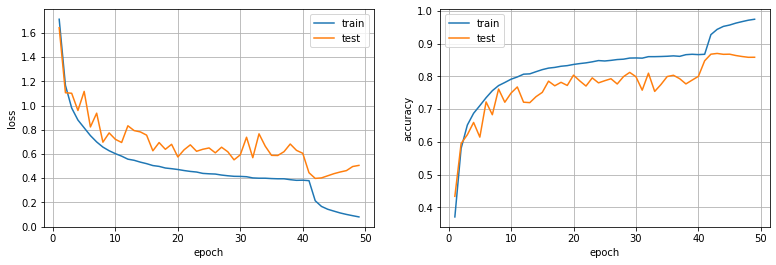

Current best test accuracy: 0.8702


Training 50/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
network = Img_CIFARResNet20_TT(ranks=[(9, 8, 4), (9, 36, 16), (9, 144, 16)]).to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device)

# Resnet20 with only last decomposed block out of 3

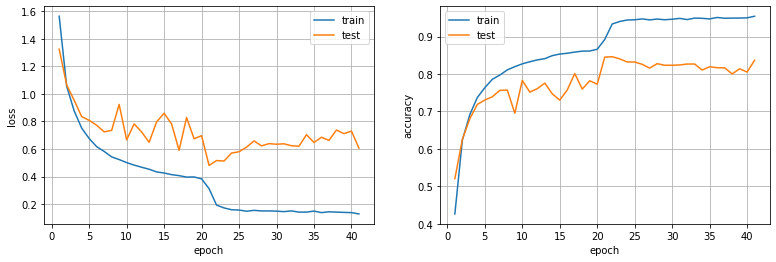

Current best test accuracy: 0.846
Best test accuracy: 0.846


In [ ]:
torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
network = Img_CIFARResNet20_TT_semi(ranks=[None, None, (9, 20, 16)]).to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16000, 32000, 48000], gamma=0.32)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs)

# Resnet20 with only last decomposed layer out of 19

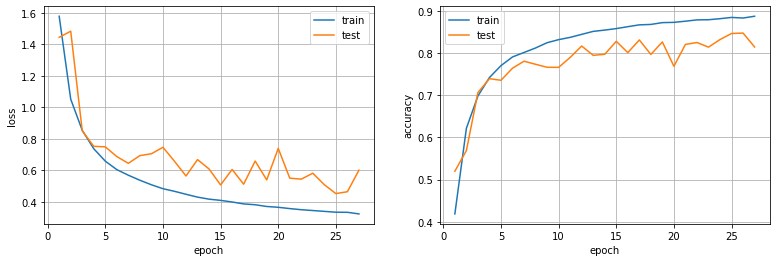

Current best test accuracy: 0.8474


Training 28/82:   0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
network = Img_CIFARResNet20_TT_last().to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device)

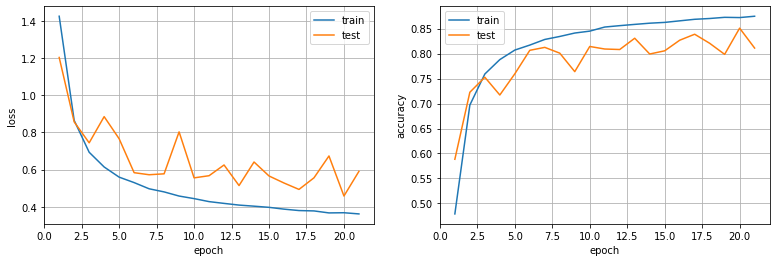

Current best test accuracy: 0.851


Training 22/82:   0%|          | 0/782 [00:00<?, ?it/s]

Testing 22/82:   0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
network = Img_CIFARResNet20_TT().to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device)

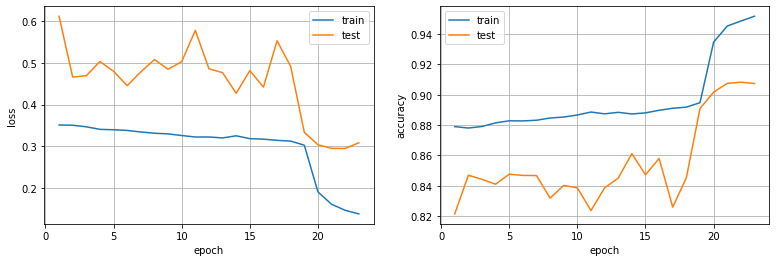

Current best test accuracy: 0.9083


Training 24/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

network = Img_CIFARResNet20_TT()
network.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/network.pt'), map_location=torch.device('cpu')))
network = network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
optimizer.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/optim.pt'), map_location=torch.device('cpu')))

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
scheduler.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/sched.pt'), map_location=torch.device('cpu')))

criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device)

# Trying to use TPU

In [ ]:
!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 152.9 MB 39 kB/s 
     |████████████████████████████████| 57 kB 2.8 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.310 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


In [ ]:
import torch_xla.core.xla_model as xm

device = xm.xla_device()

In [ ]:
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

train_set = CIFAR10('CIFAR10', train=True, download=True, transform=T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]))
test_set = CIFAR10('CIFAR10', train=False, download=True, transform=T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]))

train_sampler = torch.utils.data.distributed.DistributedSampler(
      train_set,
      num_replicas=xm.xrt_world_size(),
      rank=xm.get_ordinal(),
      shuffle=True
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch_xla.distributed.parallel_loader as pl
import time

def process_tpu(network, optimizer, scheduler, criterion, num_epochs, device):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        network.train()
        running_loss, running_accuracy = 0.0, 0.0
        para_loader = pl.ParallelLoader(train_loader, [device])

        tracker = xm.RateTracker()
        for x, (images, labels) in enumerate(para_loader.per_device_loader(device)):
            optimizer.zero_grad()
            
            logits = network(images)
            loss = criterion(logits, labels)
            loss.backward()
            xm.optimizer_step(optimizer)
            scheduler.step()
            
            running_loss += loss.item() * images.shape[0]
            running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
            tracker.add(train_loader.batch_size)

            if x % 1 == 0:
                print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}'.format(
                    xm.get_ordinal(), x, loss.item(), tracker.rate(),
                    tracker.global_rate(), time.asctime()), flush=True)
            
        train_losses += [running_loss / len(train_loader.dataset)]
        train_accuracies += [running_accuracy / len(train_loader.dataset)]
        
        network.eval()
        running_loss, running_accuracy = 0.0, 0.0
        para_loader = pl.ParallelLoader(test_loader, [device])
        
        for images, labels in tqdm(para_loader.per_device_loader(device), desc=f'Testing {epoch}/{num_epochs}'):            
            with torch.no_grad():
                logits = network(images)
                loss = criterion(logits, labels)
            
            running_loss += loss.item() * images.shape[0]
            running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
            
        test_losses += [running_loss / len(test_loader.dataset)]
        test_accuracies += [running_accuracy / len(test_loader.dataset)]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
        print(f'Current best test accuracy: {max(test_accuracies)}')

        torch.save(network.state_dict(), os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/network.pt'))
        torch.save(optimizer.state_dict(), os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/optim.pt'))
        torch.save(scheduler.state_dict(), os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/sched.pt'))

In [ ]:
torch.random.manual_seed(123)

network = Img_CIFARResNet20_TT()
network.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/network.pt'), map_location=torch.device('cpu')))
network = network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=0.1 * xm.xrt_world_size(), weight_decay=1e-4, momentum=0.9)
optimizer.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/optim.pt'), map_location=torch.device('cpu')))

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
scheduler.load_state_dict(torch.load(os.path.join(os.getcwd(), 'drive/MyDrive/my_libs/sched.pt'), map_location=torch.device('cpu')))

criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process_tpu(network, optimizer, scheduler, criterion, num_epochs, device)

# ResNet32 with full ranks

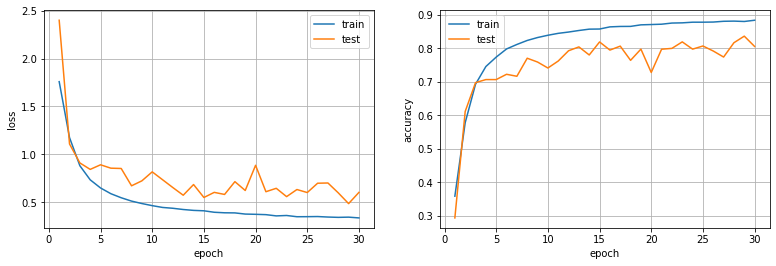

Current best test accuracy: 0.8357


Training 31/82:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
torch.random.manual_seed(123)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
network = Img_CIFARResNet32_TT().to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 82

process(network, optimizer, scheduler, criterion, num_epochs, device)